In [2]:
import pandas as pd
import numpy as np
from transformers import BertTokenizerFast
import torch

In [3]:
from time import time

before = time()

for i in range(10000000):
    pass

print(time()-before)

0.16552448272705078


In [2]:
def list_cuda_devices():
    if not torch.cuda.is_available():
        print("CUDA is not available on this system.")
        return

    num_devices = torch.cuda.device_count()
    print(f"Number of CUDA devices: {num_devices}\n")

    for device_id in range(num_devices):
        device_name = torch.cuda.get_device_name(device_id)
        compute_capability = torch.cuda.get_device_capability(device_id)
        memory = torch.cuda.get_device_properties(device_id).total_memory / (1024 ** 3)  # Convert bytes to GB
        print(f"Device ID: {device_id}")
        print(f"  Name: {device_name}")
        print(f"  Compute Capability: {compute_capability[0]}.{compute_capability[1]}")
        print(f"  Total Memory: {memory:.2f} GB\n")

# Run the function
list_cuda_devices()

Number of CUDA devices: 8

Device ID: 0
  Name: NVIDIA L40S
  Compute Capability: 8.9
  Total Memory: 44.42 GB

Device ID: 1
  Name: NVIDIA L40S
  Compute Capability: 8.9
  Total Memory: 44.42 GB

Device ID: 2
  Name: NVIDIA L40S
  Compute Capability: 8.9
  Total Memory: 44.42 GB

Device ID: 3
  Name: NVIDIA L40S
  Compute Capability: 8.9
  Total Memory: 44.42 GB

Device ID: 4
  Name: NVIDIA L40S
  Compute Capability: 8.9
  Total Memory: 44.42 GB

Device ID: 5
  Name: NVIDIA L40S
  Compute Capability: 8.9
  Total Memory: 44.42 GB

Device ID: 6
  Name: NVIDIA L40S
  Compute Capability: 8.9
  Total Memory: 44.42 GB

Device ID: 7
  Name: NVIDIA L40S
  Compute Capability: 8.9
  Total Memory: 44.42 GB



# CELER

In [2]:
eyemovement_df_c = pd.read_csv("./Data/celer/data_v2.0/sent_fix.tsv", delimiter='\t').head(100)
word_info_df_c = pd.read_csv("./Data/celer/data_v2.0/sent_ia.tsv", delimiter='\t').head(100)
sub_metadata_path_c = pd.read_csv("./Data/celer/metadata.tsv", delimiter='\t').head(100)

/tmp/ipykernel_2879708/3962079886.py:1: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  eyemovement_df_c = pd.read_csv("./Data/celer/data_v2.0/sent_fix.tsv", delimiter='\t').head(100)


# OneStop

In [3]:
eyemovement_df_o = pd.read_csv("/data/home/shared/onestop/OneStop_v1_20250126/lacclab_processed/fixations_Paragraph.csv", engine="pyarrow")
word_info_df_o = pd.read_csv("/data/home/shared/onestop/OneStop_v1_20250126/lacclab_processed/ia_Paragraph.csv", engine="pyarrow")
# sub_metadata_path_o = pd.read_csv("../OneStop-Eye-Movements/data/session_summary.csv")

In [5]:
x = eyemovement_df_o.head(100)

In [10]:
x = word_info_df_o[["unique_paragraph_id", "text_spacing_version", "participant_id"]].drop_duplicates().participant_id.values[0]
x

'l42_2070'

In [12]:
#1_0_Adv_1, 0, l2_65, l15_45

y = word_info_df_o[(word_info_df_o["unique_paragraph_id"] == "1_0_Adv_1") & (word_info_df_o["text_spacing_version"] == 0)]
y = y.drop_duplicates(["unique_paragraph_id", "text_spacing_version"]).participant_id.values[0]
y


'l21_102'

### Figuring out number of max tokens and length of a paragraph
```
"max_sn_len": 167, # max number of words in a paragraph, include start token and end token
"max_sn_token": 224, # maximum number of tokens a paragraph includes. include start token and end token
```

In [7]:
#initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained(cf["model_pretrained"])

In [8]:
max_sn_len = 0
max_sn_token = 0
sn_len_list = []
sn_token_list = []
for p in eyemovement_df_o['paragraph'].unique():
    p = ('[CLS]' + ' ' + p + ' ' + '[SEP]').split() # add special tokens
    tokens = tokenizer.tokenize(p, add_special_tokens=False, is_split_into_words=True)
    sn_len = len(p)
    sn_token_len = len(tokens)
    sn_len_list.append(sn_len)
    sn_token_list.append(sn_token_len)
    max_sn_len = max(len(p), max_sn_len)
    max_sn_token = max(len(tokens), max_sn_token)

print(max_sn_len)
print(max_sn_token)

167
224


### Figuring out number of max tokens and length in a scan path (without outlier filtering)
```
"max_sp_len": 671, # max number of words in a scanpath, include start token and end token
"max_sp_token": 851, # maximum number of tokens a scanpath includes. include start token and end token
```

In [9]:
def create_concatenated_list(df):
    result = []
    # Group by 'participant_id' and 'TRIAL_INDEX'
    grouped = df.groupby(['participant_id', 'TRIAL_INDEX'])
    for (participant_id, trial_index), group in grouped:
        # Filter out rows where CURRENT_FIX_INTEREST_AREA_LABEL is '.'
        filtered_labels = group['CURRENT_FIX_INTEREST_AREA_LABEL'].loc[group['CURRENT_FIX_INTEREST_AREA_LABEL'] != '.']
        # Concatenate the labels with '[CLS]' at the start and '[SEP]' at the end
        concatenated = "[CLS] " + " ".join(filtered_labels) + " [SEP]"
        result.append(concatenated)
    return result

# Generate the list
output_list = create_concatenated_list(eyemovement_df_o)

In [12]:
max_sp_len = 0
max_sp_token = 0
sp_len_list = []
sp_token_list = []
for sp in output_list:
    sp = ('[CLS]' + ' ' + sp + ' ' + '[SEP]').split() # add special tokens
    tokens = tokenizer.tokenize(sp, add_special_tokens=False, is_split_into_words=True)
    sp_len = len(sp)
    sp_token_len = len(tokens)
    sp_len_list.append(sp_len)
    sp_token_list.append(sp_token_len)
    max_sp_len = max(len(sp), max_sp_len)
    max_sp_token = max(len(tokens), max_sp_token)

print(max_sp_len)
print(max_sp_token)

Token indices sequence length is longer than the specified maximum sequence length for this model (603 > 512). Running this sequence through the model will result in indexing errors


674
853


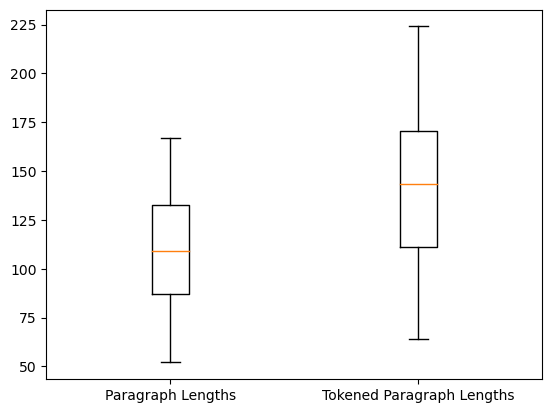

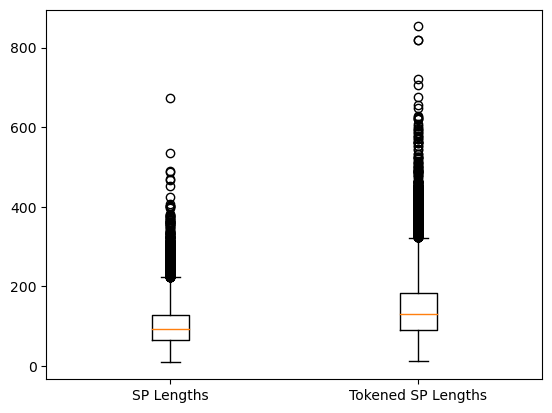

In [26]:
import matplotlib.pyplot as plt

plt.boxplot([sn_len_list, sn_token_list], labels=["Paragraph Lengths", "Tokened Paragraph Lengths"])
plt.show()

plt.boxplot([sp_len_list, sp_token_list], labels=["SP Lengths", "Tokened SP Lengths"])
plt.show()

In [34]:
# Sample DataFrame
def calculate_bp_bounds(data):
    df = pd.DataFrame(data, columns=['values'])

    # Step 1: Calculate Q1, Q3, and IQR
    Q1 = df['values'].quantile(0.25)
    Q3 = df['values'].quantile(0.75)
    IQR = Q3 - Q1

    # Step 2: Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (lower_bound, upper_bound)

def outliers_num(l, bounds):
    num_outliers = len([i for i in l if i < bounds[0] or i > bounds[1]])
    prc_outliers = 100*(num_outliers/len(l))

    return num_outliers, prc_outliers

def outlier_report(data):
    bounds = calculate_bp_bounds(data)
    num_outliers, prc_outliers = outliers_num(data, bounds)

    print(f"Paragraph lengths BP bounds are: {bounds}, # outliers: {num_outliers}, % outliers: {prc_outliers}")
    

In [35]:
outlier_report(sn_len_list)
outlier_report(sn_token_list)
outlier_report(sp_len_list)
outlier_report(sp_token_list)

Paragraph lengths BP bounds are: (18.375, 201.375), # outliers: 0, % outliers: 0.0
Paragraph lengths BP bounds are: (21.375, 260.375), # outliers: 0, % outliers: 0.0
Paragraph lengths BP bounds are: (-28.5, 223.5), # outliers: 650, % outliers: 2.703152291441404
Paragraph lengths BP bounds are: (-49.5, 322.5), # outliers: 675, % outliers: 2.8071196872660735


# Trials

In [3]:
print(eyemovement_df_o.shape)
print(eyemovement_df_o[eyemovement_df_o["article_id"] != 0].shape)


(1172718, 280)
(1114034, 280)


In [15]:
len((eyemovement_df_o['article_id'].astype(str) + '_' + eyemovement_df_o['paragraph_id'].astype(str)).unique())
print(sorted((eyemovement_df_o['article_id'].astype(str) + '_' + eyemovement_df_o['paragraph_id'].astype(str)).unique(), key=lambda x: (int(x.split('_')[0]), int(x.split('_')[1]))))

['0_1', '0_2', '1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7', '2_1', '2_2', '2_3', '2_4', '2_5', '2_6', '3_1', '3_2', '3_3', '3_4', '3_5', '4_1', '4_2', '4_3', '4_4', '4_5', '4_6', '4_7', '5_1', '5_2', '5_3', '5_4', '5_5', '6_1', '6_2', '6_3', '6_4', '6_5', '6_6', '6_7', '7_1', '7_2', '7_3', '7_4', '7_5', '7_6', '7_7', '8_1', '8_2', '8_3', '8_4', '8_5', '8_6', '9_1', '9_2', '9_3', '9_4', '9_5', '9_6', '10_1', '10_2', '10_3', '10_4', '10_5', '10_6', '10_7']


In [3]:
word_info_df_o.groupby(["unique_paragraph_id", "participant_id"]).size().to_frame('size')

size
unique_paragraph_id participant_id      
1_0_Adv_1           l10_269          128
                    l10_39           128
                    l11_40           128
                    l11_91           128
                    l12_41           128
...                                  ...
3_9_Ele_4           l60_518           78
                    l6_329           156
                    l6_330           156
                    l8_335            78
                    l8_339            78

[20158 rows x 1 columns]

In [4]:
# Assuming word_info_df_o is already defined
grouped_counts = word_info_df_o[word_info_df_o["repeated_reading_trial"] == 0].groupby(["unique_paragraph_id", "participant_id"]).size().to_frame('size')

# Find unique values per combination
unique_values_per_group = grouped_counts.reset_index().groupby(["unique_paragraph_id"])["size"].unique()

# Display results
unique_values_per_group

unique_paragraph_id
1_0_Adv_1          [128]
1_0_Adv_2          [148]
1_10_Adv_1      [99, 98]
1_10_Adv_2          [89]
1_10_Adv_3         [109]
                 ...    
3_9_Adv_4          [124]
3_9_Ele_1           [65]
3_9_Ele_2          [121]
3_9_Ele_3     [123, 122]
3_9_Ele_4           [78]
Name: size, Length: 330, dtype: object

In [39]:
grouped_counts

size
unique_paragraph_id participant_id      
1_0_Adv_1           l10_269          138
                    l10_39            82
                    l11_40            79
                    l11_91           138
                    l12_41           132
...                                  ...
3_9_Ele_4           l60_518          103
                    l6_329           146
                    l6_330            61
                    l8_335            81
                    l8_339           100

[20158 rows x 1 columns]

In [12]:
from torchaudio.functional import edit_distance
import numpy as np

In [10]:
edit_distance([["A", "B", "C"], ["A", "B", "C"]], [["A", "B", "D"], ["A", "B", "C"]])

1

In [15]:
l1 = [
    np.array([1, 2, 3]),
    np.array([4, 5, 6])
]

l2 = [
    np.array([1]),
    np.array([4, 5, 7])
]

def NLD(ref, pred):
    return [edit_distance(r, p)/max((len(r), len(p))) for r, p in zip(ref, pred)]

NLD(l1, l2)

[0.6666666666666666, 0.3333333333333333]

In [23]:
from torcheval.metrics.functional import r2_score

t1 = torch.Tensor([[1, 2, 3, 4], [4, 5, 6, 7]])
t2 = torch.Tensor([[1, 2, 4, 4], [4, 5, 6, 7]])
r2_score(t2.T, t1.T, multioutput="raw_values")

tensor([0.8000, 1.0000])

In [10]:
from typing import List, Tuple

def get_fold_indices(i: int) -> Tuple[List[int], List[int], List[int]]:
        """
        Given a fold index i within the range [0, 9], return the indices for the test,
        validation, and training sets according to the specified folding strategy.

        Parameters:
        i (int): The fold index (should be between 0 and 9).

        Returns:
        tuple: A tuple containing the test indices (as a list), validation index (as an integer),
        and training indices (as a list).
        """
        num_folds = 10
        if i < 0 or i > num_folds - 1:
            raise ValueError("Fold index must be within the range [0, 9].")

        validation_indices = [i]

        # modulo num_folds for the wraparound
        test_indices = [(i + 1) % num_folds]
        '''
        if self.use_double_test_size:
            test_indices.append((i + 2) % self.num_folds)
        '''

        # The rest are training indices
        train_indices = [
            x
            for x in range(num_folds)
            if x not in test_indices and x not in validation_indices
        ]
        print(
            f"Test folds: {test_indices}, \
            Validation fold: {validation_indices}, \
            Train folds: {train_indices}"
        )
        return test_indices, validation_indices, train_indices

get_fold_indices(0)

Test folds: [1],             Validation fold: [0],             Train folds: [2, 3, 4, 5, 6, 7, 8, 9]


([1], [0], [2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
fold_dict = {
    0: ['1_1', '2_1', '3_1'],
    1: ['1_2', '2_2', '3_2'],
    2: ['1_3', '2_3', '3_3'],
    3: ['1_4', '2_4', '3_4'],
    4: ['1_5', '2_5', '3_5'],
    5: ['1_6', '2_6', '3_6'],
    6: ['1_7', '2_7', '3_7'],
    7: ['1_8', '2_8', '3_8'],
    8: ['1_9', '2_9', '3_9'],
    9: ['1_10', '2_10', '3_10']
}

fold_dict = {}
for i in range(10):
    fold_dict[i] = [f'{j+1}_{i+1}' for j in range(3)]

fold_dict

{0: ['1_1', '2_1', '3_1'],
 1: ['1_2', '2_2', '3_2'],
 2: ['1_3', '2_3', '3_3'],
 3: ['1_4', '2_4', '3_4'],
 4: ['1_5', '2_5', '3_5'],
 5: ['1_6', '2_6', '3_6'],
 6: ['1_7', '2_7', '3_7'],
 7: ['1_8', '2_8', '3_8'],
 8: ['1_9', '2_9', '3_9'],
 9: ['1_10', '2_10', '3_10']}

In [12]:
def load_fold_subjects():
    fold_dict = {}
    fold_sub_dict = {}
    for i in range(10):
        # Account for folds
        fold_dict[i] = [f'{j+1}_{i+1}' for j in range(3)]
        # Account for fold -> subjects
        df = pd.read_csv(f"CSD/folds_RereadStratified/subjects/fold_{i}.csv")
        sub_list = df.iloc[:, 0].values.tolist()
        fold_sub_dict[i] = sub_list

    return fold_dict, fold_sub_dict


In [8]:
pd.read_csv("ln_shared_data/onestop/OneStop_v1_20250115/lacclab_processed/ezreader_n1000_20250125.csv")

,Unnamed: 0,IA_SINGLE_FIXATION_DURATION,IA_FIRST_FIXATION_DURATION,IA_FIRST_RUN_DWELL_TIME,IA_DWELL_TIME,GP,probability_of_fixating,probability_of_fixating_once,probability_of_fixating_two_or_more_times,IA_SKIP,...,FirstPassGD,FirstPassFFD,IA_FIRST_FIX_PROGRESSIVE,IA_FIXATION_COUNT,IA_ID,text_index,total_skip,unique_paragraph_id,text_spacing_version,IA_LABEL
0,0,257,255,265,269,269,0.98,0.93,0.04,0.03,...,267,255,0.969,1.0,5,0,0.02,3_0_Adv_1,0.0,one
1,1,284,270,312,317,317,0.99,0.83,0.15,0.02,...,314,270,0.985,1.2,1,1,0.01,3_0_Adv_2,0.0,will
2,2,248,247,251,254,253,0.87,0.84,0.02,0.14,...,253,247,0.861,0.9,0,2,0.13,3_6_Ele_1,0.0,When
3,3,229,230,253,260,256,0.97,0.87,0.09,0.04,...,255,231,0.959,1.1,1,2,0.03,3_6_Ele_1,0.0,Larry
4,4,250,250,246,262,252,0.80,0.74,0.02,0.24,...,259,252,0.758,0.8,5,2,0.20,3_6_Ele_1,0.0,about
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,739,237,244,290,301,312,0.98,0.81,0.17,0.02,...,291,244,0.978,1.2,2,339,0.02,1_9_Ele_2,0.0,said
705,740,262,263,285,299,287,0.96,0.86,0.09,0.05,...,289,264,0.947,1.1,3,339,0.04,1_9_Ele_2,0.0,"that,"
706,741,282,282,279,292,289,0.73,0.69,0.01,0.30,...,290,285,0.704,0.7,6,339,0.27,1_9_Ele_2,0.0,are
707,746,204,221,233,261,259,0.80,0.69,0.07,0.24,...,245,224,0.763,0.9,6,342,0.20,2_8_Adv_5,0.0,to


In [9]:
pd.read_feather("ln_shared_data/onestop/OneStop_v1_20250115/lacclab_processed/fixations_Paragraph_with_ezreader_n1000_20250125.feather")

,participant_id,TRIAL_INDEX,CURRENT_FIX_ADJUSTED,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_BUTTON_0_PRESS,CURRENT_FIX_BUTTON_1_PRESS,CURRENT_FIX_BUTTON_2_PRESS,CURRENT_FIX_BUTTON_3_PRESS,CURRENT_FIX_BUTTON_4_PRESS,CURRENT_FIX_BUTTON_5_PRESS,...,cs_has_two_questions,question_n_condition_prediction_label,couple_question_1,couple_question_2,lonely_question,synthesized,position,text_index,IA_average_x,IA_average_y
0,l42_2070,1.0,False,NONE,.,.,.,.,.,.,...,0.0,0.0,None,None,None,real,NaN,NaN,NaN,NaN
1,l42_2070,1.0,False,NONE,.,.,.,.,.,.,...,0.0,0.0,None,None,None,real,NaN,NaN,NaN,NaN
2,l42_2070,1.0,False,NONE,.,.,.,.,.,.,...,0.0,0.0,None,None,None,real,NaN,NaN,NaN,NaN
3,l42_2070,1.0,False,NONE,.,.,.,.,.,.,...,0.0,0.0,None,None,None,real,NaN,NaN,NaN,NaN
4,l42_2070,1.0,False,NONE,.,.,.,.,.,.,...,0.0,0.0,None,None,None,real,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400783,l2_324,NaN,None,None,None,None,None,None,None,None,...,NaN,NaN,None,None,None,ezreader,NaN,8.0,1735.0,435.0
2400784,l2_324,NaN,None,None,None,None,None,None,None,None,...,NaN,NaN,None,None,None,ezreader,NaN,8.0,871.0,549.0
2400785,l2_324,NaN,None,None,None,None,None,None,None,None,...,NaN,NaN,None,None,None,ezreader,NaN,8.0,1754.0,549.0
2400786,l2_324,NaN,None,None,None,None,None,None,None,None,...,NaN,NaN,None,None,None,ezreader,NaN,8.0,1878.0,549.0


In [10]:
# Create fake data for testing
fake_unique_paragraph_ids = ["para1", "para2", "para3"]
fake_text_spacing_version = torch.rand(3)  # 1D tensor with 91 random numbers
fake_cls_dnn_sp = [torch.rand(5), torch.rand(3), torch.rand(7)]  # List of 1D tensors of various lengths
fake_reg_dnn_sp = [torch.rand(5), torch.rand(3), torch.rand(7)]  # Corresponding list of 1D tensors of the same lengths

In [24]:

def ez_reader_formatter(unique_paragraph_ids, text_spacing_version, cls_dnn_sp, reg_dnn_sp, fold):
    df_dict = {
        "fix_id": [],
        "unique_paragraph_id": [], 
        "text_spacing_version": [], 
        "sp_fix_pos": [], 
        "sp_fix_dur": []
    }
    
    text_spacing_version = text_spacing_version.numpy().tolist()

    for upi, tsv, cds, rds in zip(unique_paragraph_ids, text_spacing_version, cls_dnn_sp, reg_dnn_sp):
       assert(len(cds) == len(rds))
       sp_len = len(cds)
       df_dict["fix_id"] += list(range(sp_len))
       df_dict["unique_paragraph_id"] += [upi]*sp_len
       df_dict["text_spacing_version"] += [tsv]*sp_len
       df_dict["sp_fix_pos"] += cds.numpy().tolist()
       df_dict["sp_fix_dur"] += (rds*1000).numpy().tolist()

    output_df = pd.DataFrame.from_dict(df_dict)
    output_df.to_csv(f"results/Eyettention/test_eyettention_output_fold_{fold}.csv", index=False)
    
    return output_df


# Call the function with the fake data
ez_reader_formatter(fake_unique_paragraph_ids, fake_text_spacing_version, fake_cls_dnn_sp, fake_reg_dnn_sp, 0)

,fix_id,unique_paragraph_id,text_spacing_version,sp_fix_pos,sp_fix_dur
0,0,para1,0.575614,0.659142,219.766266
1,1,para1,0.575614,0.820403,209.858246
2,2,para1,0.575614,0.150148,128.861725
3,3,para1,0.575614,0.751434,671.844360
4,4,para1,0.575614,0.403262,980.416077
5,0,para2,0.431862,0.980065,169.597687
6,1,para2,0.431862,0.281220,443.672668
7,2,para2,0.431862,0.579710,265.391937
8,0,para3,0.759464,0.207936,688.006042
9,1,para3,0.759464,0.874366,212.673538


,participant_id,batch_id_article_id
0,l42_2070,3_3
1,l42_2070,3_6
2,l59_547,3_2
3,l59_547,3_3
4,l39_542,3_9
...,...,...
715,l6_329,3_7
716,l1_322,3_8
717,l1_322,3_3
718,l2_324,3_9


In [9]:
eyemovement_df_o["batch_id_article_id"] = eyemovement_df_o["article_batch"].astype(str) + '_' + eyemovement_df_o["article_id"].astype(str)
filter_df = pd.read_csv("reread_participant_article_combinations.csv")

In [ ]:
after = eyemovement_df_o = eyemovement_df_o[~eyemovement_df_o.set_index(['participant_id', 'batch_id_article_id']).index.isin(filter_df.set_index(['participant_id', 'batch_id_article_id']).index)]
after

,participant_id,TRIAL_INDEX,CURRENT_FIX_ADJUSTED,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_BUTTON_0_PRESS,CURRENT_FIX_BUTTON_1_PRESS,CURRENT_FIX_BUTTON_2_PRESS,CURRENT_FIX_BUTTON_3_PRESS,CURRENT_FIX_BUTTON_4_PRESS,CURRENT_FIX_BUTTON_5_PRESS,...,part_ID,normalized_ID,q_reference,cs_has_two_questions,question_n_condition_prediction_label,couple_question_1,couple_question_2,lonely_question,batch_id_article_id,list_participant_id
0,l42_2070,1,False,NONE,.,.,.,.,.,.,...,1,0.000000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
1,l42_2070,1,False,NONE,.,.,.,.,.,.,...,2,0.008000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
2,l42_2070,1,False,NONE,.,.,.,.,.,.,...,3,0.016000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
3,l42_2070,1,False,NONE,.,.,.,.,.,.,...,5,0.032000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
4,l42_2070,1,False,NONE,.,.,.,.,.,.,...,9,0.064000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399989,l2_324,53,False,BEFORE,.,.,.,.,.,.,...,69,0.978261,0.0,1,3,What is one reason for the increase in stress-...,Who is scared of disapproval from their collea...,What makes around 200 people die every year in...,3_4,l2_l2_324
2399990,l2_324,53,False,NONE,.,.,.,.,.,.,...,70,0.989130,0.0,1,3,What is one reason for the increase in stress-...,Who is scared of disapproval from their collea...,What makes around 200 people die every year in...,3_4,l2_l2_324
2399991,l2_324,53,False,NONE,.,.,.,.,.,.,...,68,0.967391,0.0,1,3,What is one reason for the increase in stress-...,Who is scared of disapproval from their collea...,What makes around 200 people die every year in...,3_4,l2_l2_324
2399992,l2_324,53,False,NONE,.,.,.,.,.,.,...,69,0.978261,0.0,1,3,What is one reason for the increase in stress-...,Who is scared of disapproval from their collea...,What makes around 200 people die every year in...,3_4,l2_l2_324


In [13]:
eyemovement_df_o

,participant_id,TRIAL_INDEX,CURRENT_FIX_ADJUSTED,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_BUTTON_0_PRESS,CURRENT_FIX_BUTTON_1_PRESS,CURRENT_FIX_BUTTON_2_PRESS,CURRENT_FIX_BUTTON_3_PRESS,CURRENT_FIX_BUTTON_4_PRESS,CURRENT_FIX_BUTTON_5_PRESS,...,part_ID,normalized_ID,q_reference,cs_has_two_questions,question_n_condition_prediction_label,couple_question_1,couple_question_2,lonely_question,batch_id_article_id,list_participant_id
0,l42_2070,1,False,NONE,.,.,.,.,.,.,...,1,0.000000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
1,l42_2070,1,False,NONE,.,.,.,.,.,.,...,2,0.008000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
2,l42_2070,1,False,NONE,.,.,.,.,.,.,...,3,0.016000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
3,l42_2070,1,False,NONE,.,.,.,.,.,.,...,5,0.032000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
4,l42_2070,1,False,NONE,.,.,.,.,.,.,...,9,0.064000,NaN,0,0,NaN,NaN,NaN,3_0,l42_l42_2070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400783,l2_324,76,False,NONE,.,.,.,.,.,.,...,5,0.656716,1.0,1,3,What is true of the cargo bike?,"According to Pizzi, what is one benefit of the...","According to Pizzi, which population is now us...",3_6,l2_l2_324
2400784,l2_324,76,False,NONE,.,.,.,.,.,.,...,15,0.805970,1.0,1,3,What is true of the cargo bike?,"According to Pizzi, what is one benefit of the...","According to Pizzi, which population is now us...",3_6,l2_l2_324
2400785,l2_324,76,False,NONE,.,.,.,.,.,.,...,23,0.925373,1.0,1,3,What is true of the cargo bike?,"According to Pizzi, what is one benefit of the...","According to Pizzi, which population is now us...",3_6,l2_l2_324
2400786,l2_324,76,False,NONE,.,.,.,.,.,.,...,24,0.940299,1.0,1,3,What is true of the cargo bike?,"According to Pizzi, what is one benefit of the...","According to Pizzi, which population is now us...",3_6,l2_l2_324


In [20]:
import pandas as pd

# Example data for df1
data1 = {'a': [1, 2, 6,  3, 4], 'b': [5, 6, 2, 7, 8], 'c': [9, 10, 23, 11, 12]}
df1 = pd.DataFrame(data1)

# Example data for df2
data2 = {'a': [2, 4], 'b': [6, 8], 'd': [13, 14]}
df2 = pd.DataFrame(data2)

# Perform the filtering
filtered_df1 = df1[~df1.set_index(['a', 'b']).index.isin(df2.set_index(['a', 'b']).index)]

# Output the result
print("\nOriginal df1:")
print(df1)

print("\nFilter df2:")
print(df2)

print("\nFiltered df1:")
print(filtered_df1)


Original df1:
   a  b   c
0  1  5   9
1  2  6  10
2  6  2  23
3  3  7  11
4  4  8  12

Filter df2:
   a  b   d
0  2  6  13
1  4  8  14

Filtered df1:
   a  b   c
0  1  5   9
2  6  2  23
3  3  7  11


In [21]:
df = pd.read_csv("CSD/folds_RereadStratified/all_folds_subjects_items_RereadStratified.csv")

,eval_regime,eval_type,fold,participant_id,article_batch,article_id
0,train,train,0,l21_102,1,3
1,train,train,0,l21_102,1,4
2,train,train,0,l21_102,1,5
3,train,train,0,l21_102,1,6
4,train,train,0,l21_102,1,7
...,...,...,...,...,...,...
35995,new_subject,val,9,l25_374,3,5
35996,new_subject,val,9,l25_374,3,6
35997,new_subject,val,9,l25_374,3,7
35998,new_subject,val,9,l25_374,3,8


In [5]:
df = pd.read_csv("CSD/folds_RereadStratified/all_folds_subjects_items_RereadStratified.csv")
df

,eval_regime,eval_type,fold,participant_id,article_batch,article_id
0,train,train,0,l21_102,1,3
1,train,train,0,l21_102,1,4
2,train,train,0,l21_102,1,5
3,train,train,0,l21_102,1,6
4,train,train,0,l21_102,1,7
...,...,...,...,...,...,...
35995,new_subject,val,9,l25_374,3,5
35996,new_subject,val,9,l25_374,3,6
35997,new_subject,val,9,l25_374,3,7
35998,new_subject,val,9,l25_374,3,8


In [10]:
eyemovement_df = eyemovement_df_o.copy()


In [11]:
eyemovement_df = eyemovement_df[eyemovement_df["repeated_reading_trial"] == 0]
eyemovement_df = eyemovement_df[eyemovement_df["question_preview"] == 0]
filter_df = pd.read_csv("reread_participant_article_combinations.csv")
eyemovement_df["batch_id_article_id"] = eyemovement_df["article_batch"].astype(str) + '_' + eyemovement_df["article_id"].astype(str)
eyemovement_df = eyemovement_df[~eyemovement_df.set_index(['participant_id', 'batch_id_article_id']).index.isin(filter_df.set_index(['participant_id', 'batch_id_article_id']).index)]

eyemovement_df

,participant_id,TRIAL_INDEX,CURRENT_FIX_ADJUSTED,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_BUTTON_0_PRESS,CURRENT_FIX_BUTTON_1_PRESS,CURRENT_FIX_BUTTON_2_PRESS,CURRENT_FIX_BUTTON_3_PRESS,CURRENT_FIX_BUTTON_4_PRESS,CURRENT_FIX_BUTTON_5_PRESS,...,reverse_part_ID,part_ID,normalized_ID,q_reference,cs_has_two_questions,question_n_condition_prediction_label,couple_question_1,couple_question_2,lonely_question,batch_id_article_id
36356,l59_485,1,False,NONE,.,.,.,.,.,.,...,-79,2,0.007812,NaN,0,3,NaN,NaN,NaN,2_0
36357,l59_485,1,False,NONE,.,.,.,.,.,.,...,-79,2,0.007812,NaN,0,3,NaN,NaN,NaN,2_0
36358,l59_485,1,False,AFTER,.,.,.,.,.,.,...,-79,2,0.007812,NaN,0,3,NaN,NaN,NaN,2_0
36359,l59_485,1,False,BEFORE,.,.,.,.,.,.,...,-79,2,0.007812,NaN,0,3,NaN,NaN,NaN,2_0
36360,l59_485,1,False,NONE,.,.,.,.,.,.,...,-78,3,0.015625,NaN,0,3,NaN,NaN,NaN,2_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399989,l2_324,53,False,BEFORE,.,.,.,.,.,.,...,-2,69,0.978261,0.0,1,3,What is one reason for the increase in stress-...,Who is scared of disapproval from their collea...,What makes around 200 people die every year in...,3_4
2399990,l2_324,53,False,NONE,.,.,.,.,.,.,...,-1,70,0.989130,0.0,1,3,What is one reason for the increase in stress-...,Who is scared of disapproval from their collea...,What makes around 200 people die every year in...,3_4
2399991,l2_324,53,False,NONE,.,.,.,.,.,.,...,-3,68,0.967391,0.0,1,3,What is one reason for the increase in stress-...,Who is scared of disapproval from their collea...,What makes around 200 people die every year in...,3_4
2399992,l2_324,53,False,NONE,.,.,.,.,.,.,...,-2,69,0.978261,0.0,1,3,What is one reason for the increase in stress-...,Who is scared of disapproval from their collea...,What makes around 200 people die every year in...,3_4


In [13]:
eyemovement_df[eyemovement_df["article_id"] != 0].drop_duplicates(subset=["unique_paragraph_id", "participant_id"])

,participant_id,TRIAL_INDEX,CURRENT_FIX_ADJUSTED,CURRENT_FIX_BLINK_AROUND,CURRENT_FIX_BUTTON_0_PRESS,CURRENT_FIX_BUTTON_1_PRESS,CURRENT_FIX_BUTTON_2_PRESS,CURRENT_FIX_BUTTON_3_PRESS,CURRENT_FIX_BUTTON_4_PRESS,CURRENT_FIX_BUTTON_5_PRESS,...,reverse_part_ID,part_ID,normalized_ID,q_reference,cs_has_two_questions,question_n_condition_prediction_label,couple_question_1,couple_question_2,lonely_question,batch_id_article_id
36628,l59_485,3,False,BEFORE,.,.,.,.,.,.,...,-31,1,0.000000,0.0,1,3,Where does Clay Cockrell hold his popular ther...,What is opposite Cockrell’s office?,What was Cockrell’s occupation before taking o...,2_7
36691,l59_485,4,False,NONE,.,.,.,.,.,.,...,-31,1,0.000000,1.0,0,3,Who thinks that the problems of the wealthy ar...,What do the wealthy feel is not real?,What do wealthy people feel guilty about?,2_7
36808,l59_485,5,False,NONE,.,.,.,.,.,.,...,-44,2,0.010309,0.0,0,3,What does Traeger-Muney imply people say about...,What is Traeger-Muney sometimes shocked by?,"How does the media affect rich people, accordi...",2_7
36916,l59_485,6,False,NONE,.,.,.,.,.,.,...,-23,2,0.008197,0.0,1,3,What is the quote ‘I am broke. Things are hard...,What is the quote ‘I have a ton of money’ an e...,"According to Cockrell, why do the wealthy tend...",2_7
37020,l59_485,7,False,NONE,.,.,.,.,.,.,...,-57,2,0.007692,1.0,1,3,What is something that got worse for the wealt...,How have things changed for the wealthy since ...,What is excluded from the presented wealth est...,2_7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399630,l2_324,49,False,AFTER,.,.,.,.,.,.,...,-52,1,0.000000,1.0,1,3,What does the Japanese government want workers...,Who or what is driving the change in Japanese ...,Why would someone be considered disloyal to th...,3_4
2399666,l2_324,50,False,NONE,.,.,.,.,.,.,...,-55,1,0.000000,0.0,1,3,What are Japanese workers likely to think abou...,What are British workers likely to think about...,What does the government hope will happen by 2...,3_4
2399775,l2_324,51,False,NONE,.,.,.,.,.,.,...,-63,1,0.000000,1.0,1,3,What is increasingly happening to Japanese emp...,What has increased because of the Japanese cul...,How do people in the world view the Japanese e...,3_4
2399850,l2_324,52,False,NONE,.,.,.,.,.,.,...,-25,2,0.006289,0.0,0,3,What does Yuu Wakebe say about Japanese employ...,What does Yuu Wakebe’s quote convey about work...,Who says that Japanese workers don’t use their...,3_4


In [4]:
df = pd.read_csv("results/Eyettention/full_eyettention_output_fold_0_run_1.csv")
df = df.drop_duplicates(subset=["unique_paragraph_id", "text_spacing_version"])
df

,fix_id,unique_paragraph_id,text_spacing_version,sp_fix_pos,sp_fix_dur
0,0,1_3_Adv_4,0,0,0.0
1771,0,1_3_Adv_3,0,0,0.0
3359,0,1_3_Ele_1,0,0,0.0
4553,0,1_3_Ele_5,0,0,0.0
6276,0,1_3_Ele_2,0,0,0.0
...,...,...,...,...,...
890045,0,3_2_Ele_1,0,0,0.0
893222,0,3_2_Ele_5,0,0,0.0
896256,0,3_2_Adv_4,0,0,0.0
899586,0,3_2_Ele_2,0,0,0.0
